# 3 Predictive Analytics: 
Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in **forecasting total system-level demand in the next hour**. To do so, develop a prediction model that **predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data).**

1. Feature Engineering: **Develop a rich set of features that you expect to be correlated with your target**. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.

2. Model Building: Select **three regression algorithms** that are suitable for the prediction task at hand. **Explain and justify** why you selected the three algorithms and describe their respective advantages and drawbacks.

3. Model Evaluation: **How well do the models perform? Evaluate and benchmark your models’ performance using suitable evaluation metrics. Which model would you select for deployment?**

4. Outlook: How could the selected model be improved further? Explain some of the improvement levers that you might focus on in a follow-up project.

Notes and tipps

- Make generous use of visualization techniques to clearly illustrate your findings and present them in an appealing fashion.
- Evaluate your methodology and clearly state why you have opted for a specific approach in your analysis.
- Relate your findings to the real world and interpret them for non-technical audiences (e.g. What do the coefficients in your regression model mean?, What does the achieved error mean for your model?, etc.)
- Make sure to clearly state the implications (i.e. the ”so what?”) of your findings for managers/decision makers.

## 3.1 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import statistics
import timeit


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import random
random.seed(42)

%matplotlib inline

Import of data

In [2]:
df_trips = pd.read_csv('data/boston_2017_cleaned_trips.csv')
df_weather = pd.read_csv('data/weather_2017_cleaned.csv')

## 3.2 Data Preparation

In advance of building the models suitable variables are enginered that help the prediction. 

In [3]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310760 entries, 0 to 1310759
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   start_time          1310760 non-null  object 
 1   end_time            1310760 non-null  object 
 2   start_station_id    1310760 non-null  int64  
 3   end_station_id      1310760 non-null  int64  
 4   start_station_name  1310760 non-null  object 
 5   end_station_name    1310760 non-null  object 
 6   bike_id             1310760 non-null  int64  
 7   user_type           1310760 non-null  object 
 8   start_hour          1310760 non-null  int64  
 9   weekday             1310760 non-null  int64  
 10  duration            1310760 non-null  float64
 11  month               1310760 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 120.0+ MB


Our pre-processed data already contains various information about the temporal patterns e.g. the start time furthermore the hour, weekday and month of the trips.

In [4]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   max_temp   8760 non-null   float64
 1   min_temp   8760 non-null   float64
 2   precip     8760 non-null   float64
 3   date_time  8760 non-null   object 
dtypes: float64(3), object(1)
memory usage: 273.9+ KB


In [5]:
df_trips['start_date'] = df_trips['start_time']
df_trips.set_index('start_date', inplace = True)
df_trips.index = pd.to_datetime(df_trips.index)

In [6]:
# Calculating the total amount of trips started per hour
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips_group = df_trips.groupby(pd.Grouper(key='start_time', freq='H')).count()
df_trips_group['end_time']

start_time
2017-01-01 00:00:00    13
2017-01-01 01:00:00     7
2017-01-01 02:00:00     4
2017-01-01 03:00:00     2
2017-01-01 04:00:00     6
                       ..
2017-12-31 19:00:00     6
2017-12-31 20:00:00     5
2017-12-31 21:00:00     3
2017-12-31 22:00:00     7
2017-12-31 23:00:00     2
Freq: H, Name: end_time, Length: 8760, dtype: int64

In [7]:
hourly_demand = df_trips_group['end_time']
hourly_demand

start_time
2017-01-01 00:00:00    13
2017-01-01 01:00:00     7
2017-01-01 02:00:00     4
2017-01-01 03:00:00     2
2017-01-01 04:00:00     6
                       ..
2017-12-31 19:00:00     6
2017-12-31 20:00:00     5
2017-12-31 21:00:00     3
2017-12-31 22:00:00     7
2017-12-31 23:00:00     2
Freq: H, Name: end_time, Length: 8760, dtype: int64

In [8]:
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
df_weather.set_index('date_time', inplace = True)

Creating the dataset with the grouped demand

In [9]:
df_pred_feat = df_weather
df_pred_feat["hourly_demand"] = hourly_demand

## Feature Engineering

In [10]:
# basic temporal features
df_pred_feat["hour"] = df_pred_feat.index.hour
df_pred_feat["weekday"] = df_pred_feat.index.weekday
df_pred_feat["month"] = df_pred_feat.index.month

In [11]:
# advances temporal features and dummy encoding
df_pred_feat['is_workday'] = df_pred_feat['weekday'].apply(lambda x: 1 if x < 5 else 0)
df_pred_feat['peak_hour_1'] = df_pred_feat['hour'].apply(lambda x: 1 if x > 6 & x < 10 else 0)
df_pred_feat['peak_hour_2'] = df_pred_feat['hour'].apply(lambda x: 1 if x > 11 & x < 20 else 0)
df_pred_feat['hour_dummy'] = df_pred_feat['hour']
df_pred_feat = pd.get_dummies(df_pred_feat, columns = ['hour_dummy'])
df_pred_feat['quarter'] = df_pred_feat['month'].apply(lambda x: x // 4)
df_pred_feat = pd.get_dummies(df_pred_feat, columns = ['quarter'])

As hour and weekday are cyclical features the sin and cos components are calculated to preserve information such as hour 23 and hour 0 being close to each other and not far.

In [12]:
df_pred_feat['hour_sin'] = np.sin(df_pred_feat.hour*(2.*np.pi/24))
df_pred_feat['hour_cos'] = np.cos(df_pred_feat.hour*(2.*np.pi/24))
# month values between 0 and 11 
df_pred_feat['month_sin'] = np.sin((df_pred_feat.month-1)*(2.*np.pi/12))
df_pred_feat['month_cos'] = np.cos((df_pred_feat.month-1)*(2.*np.pi/12))

In [13]:
df_pred_feat.groupby('hour').sum()["hourly_demand"]
#df_pred_feat.groupby('month').sum()["hourly_demand"]

hour
0       9866
1       6327
2       3937
3       1564
4       1806
5       7128
6      25965
7      72051
8     124150
9      75123
10     55609
11     61137
12     72006
13     71305
14     70861
15     78777
16    113096
17    147961
18    108039
19     73514
20     50700
21     35688
22     26777
23     17373
Name: hourly_demand, dtype: int64

In [14]:
# scale temperature features 
mean_temp = statistics.mean(df_pred_feat['max_temp'])
std_temp = statistics.stdev(df_pred_feat['max_temp'])
df_pred_feat['max_temp_scaled'] = (df_pred_feat['max_temp'] - mean_temp) / std_temp

## Feature Correlation

The heatmap shows the correlation between the features. From this insights can be derieved which features are usefull for the prediction models.

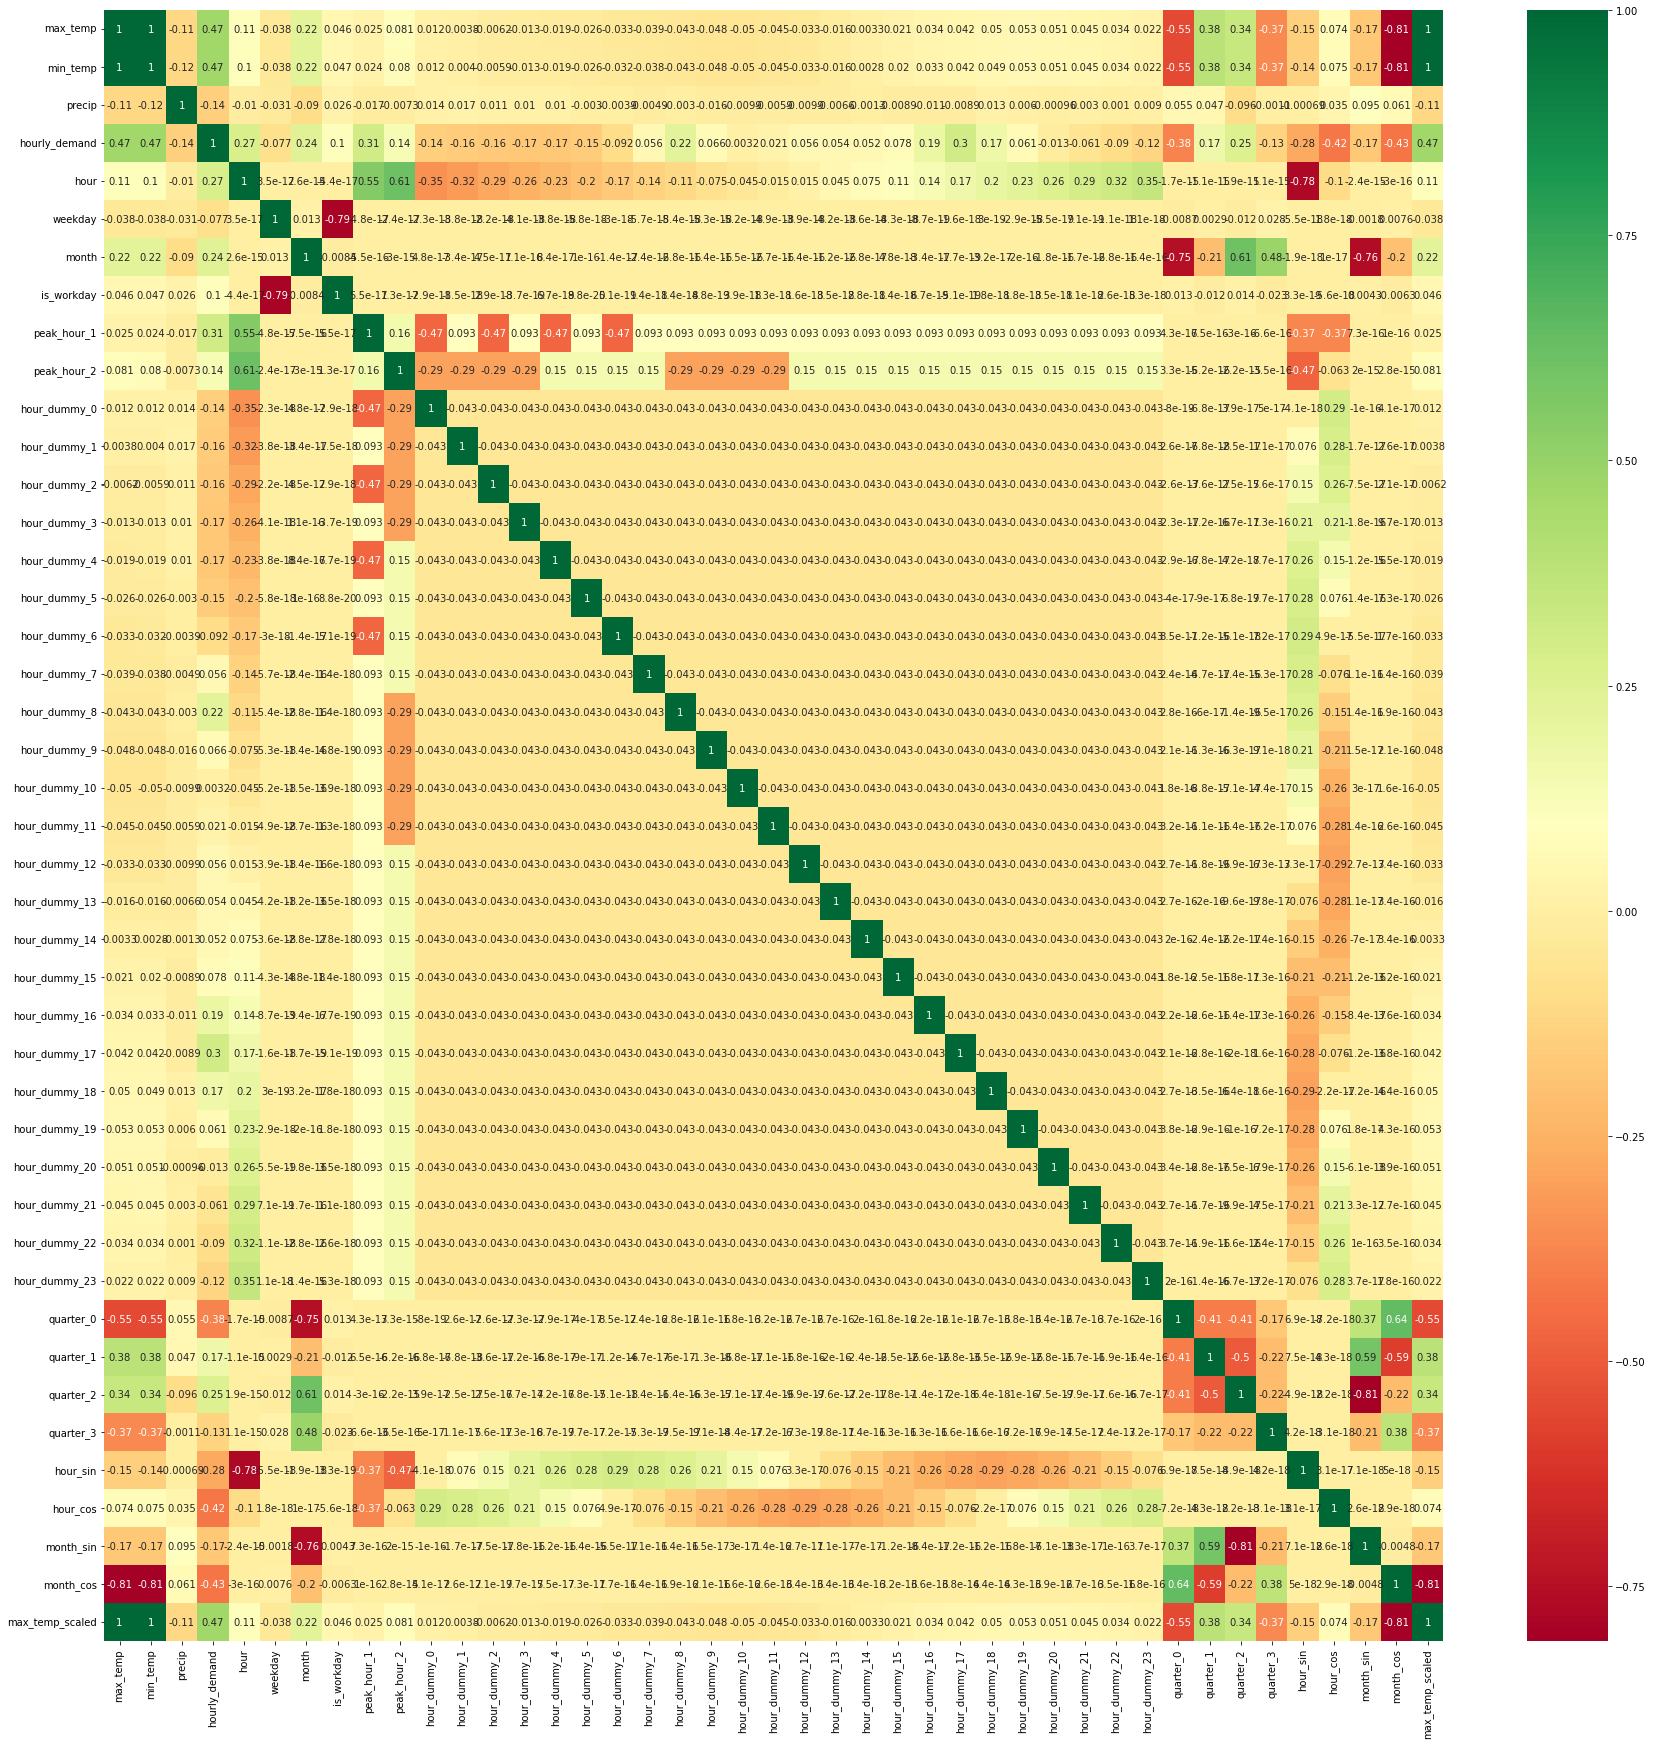

In [15]:
corrmat = df_pred_feat.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(30,30))

g=sns.heatmap(df_pred_feat[top_corr_features].corr(),annot=True, cmap="RdYlGn")

## 3.3 Model Building

Now the prediciton models can be created. Starting with simple prediciton models like Linear Regression or Polinomial Regression. Afterwards more complex Algorithms like Random Forest, SVR, XGBoost and neural networks are created.

### Function for Data Splitting 

allows dropping specifyied features.

### Function for Model Evaluation 

In [16]:
def get_metrics(y_test, y_test_pred):
    print ('R²: ', r2_score(y_test, y_test_pred))
    print ('MAE: ', mean_absolute_error(y_test, y_test_pred))
    print ('RMSE: ', mean_squared_error(y_test, y_test_pred, squared = False), "\n")

### Model Building and Evaluation

In [17]:
def data_split(features):
    features.append('hourly_demand')
    features.append(features.pop(features.index('hourly_demand')))
    df = df_pred_feat[features]

    # split the data with 70% training data
    train, test = train_test_split(df, test_size = 0.3, random_state = 42)
    x_train = train.iloc[:,:-1]
    y_train = train.iloc[:,-1]

    x_test = test.iloc[:,:-1]
    y_test = test.iloc[:,-1]
    
    return x_train, y_train, x_test, y_test

In [ ]:
a = [['hour']

In [18]:
def model_comparison(feature_list):
    
    storage = pd.DataFrame()
    
    for n in range(len(feature_list)):

        x_train, y_train, x_test, y_test = data_split(feature_list[n])
        models=[LinearRegression(normalize = True), LinearRegression(normalize = True), RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(),xgb.XGBRegressor()]
        model_names=['LinearRegression 1st Degree','LinearRegression 3th Degree','RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor','XGBoost']
        
        mono_reg = PolynomialFeatures (degree = 1)
        x_mono = mono_reg.fit_transform(x_train)
       
        poly_reg = PolynomialFeatures (degree = 3)
        x_poly = poly_reg.fit_transform(x_train)

        for model in range (len(models)):
            clf = models[model]
            
            if(model == 0):
                clf.fit(x_mono, y_train)
                test_pred = clf.predict(mono_reg.fit_transform(x_test))
                
            if(model == 1):
                clf.fit(x_poly, y_train)
                test_pred = clf.predict(poly_reg.fit_transform(x_test))
            
            else:
                clf.fit(x_train,y_train)
                test_pred = clf.predict(x_test)
                
            r2 = (r2_score(y_test, test_pred))
            mae = (mean_absolute_error(y_test, test_pred))
            rmse = (mean_squared_error(y_test, test_pred, squared = False))
            #storage = storage.append({'Features':str(feature_list[n]), 'Model':model_names[model],'RMSE':rmse, 'MAE':mae, 'R2':r2}, ignore_index=True)
            storage = storage.append({'Features':str(n) + ' ' + str(feature_list[n]), 'Model':model_names[model], 'R2':r2}, ignore_index=True)

    return storage

In [19]:
test_feature_row_1 = ['hour']
test_feature_row_2 = ['hour', 'month']
test_feature_row_3 = ['hour', 'month', 'weekday']
test_feature_row_4 = ['hour', 'month', 'is_workday']
test_feature_row_5 = ['hour', 'month', 'weekday', 'is_workday']
test_feature_row_6 = ['hour', 'month', 'weekday', 'is_workday', 'precip']
test_feature_row_7 = ['hour', 'month', 'weekday', 'is_workday', 'precip', 'max_temp']
test_feature_row_8 = ['hour', 'month', 'weekday', 'is_workday', 'precip', 'max_temp_scaled']
test_feature_row_9 = ['hour', 'month', 'weekday', 'is_workday', 'precip', 'max_temp_scaled', 'quarter_0', 'quarter_1', 'quarter_2', 'quarter_3']
test_feature_row_10 = ['hour', 'month', 'weekday', 'is_workday', 'precip', 'max_temp_scaled', 'peak_hour_1', 'peak_hour_2']


featureList = [test_feature_row_1, test_feature_row_2, test_feature_row_3, test_feature_row_4, test_feature_row_5, test_feature_row_6, test_feature_row_7, test_feature_row_8,test_feature_row_9, test_feature_row_10]

model_comp_grid = model_comparison(featureList)

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

In [20]:
model_comp_grid.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              AdaBoostRegressor   
Features                                                               
0 ['hour', 'hourly_demand']                                 0.373065   
1 ['hour', 'month', 'hourly_demand']                        0.663215   
2 ['hour', 'month', 'weekday', 'hourly_demand']             0.666174   
3 ['hour', 'month', 'is_workday', 'hourly_demand']          0.681095   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...          0.683005   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.678056   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.682159   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.675969   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.683485   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.676889   

                                                                     \
Model                                              BaggingRegressor   
Features                                                              
0 ['hour', 'hourly_demand']                                0.413813   
1 ['hour', 'month', 'hourly_demand']                       0.749635   
2 ['hour', 'month', 'weekday', 'hourly_demand']            0.827199   
3 ['hour', 'month', 'is_workday', 'hourly_demand']         0.860201   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...         0.815711   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.866985   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.906450   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.907828   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.908280   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.900136   

                                                                        \
Model                                              KNeighborsRegressor   
Features                                                                 
0 ['hour', 'hourly_demand']                                   0.344877   
1 ['hour', 'month', 'hourly_demand']                          0.706370   
2 ['hour', 'month', 'weekday', 'hourly_demand']               0.830499   
3 ['hour', 'month', 'is_workday', 'hourly_demand']            0.833956   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...            0.831235   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.849088   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.856567   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.891403   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.892379   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.893367   

                                                                                \
Model                                              LinearRegression 1st Degree   
Features                                                                         
0 ['hour', 'hourly_demand']                                           0.064920   
1 ['hour', 'month', 'hourly_demand']                                  0.122674   
2 ['hour', 'month', 'weekday', 'hourly_demand']                       0.129878   
3 ['hour', 'month', 'is_workday', 'hourly_demand']                    0.137453   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...                    0.137496   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.148279   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.290768   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.290768   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.306860   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.330846   

                                                                                \
Model                                              LinearRegression 3th Degree   
Features   

In [21]:
test_feature_row_11 = ['hour', 'month', 'weekday']
test_feature_row_12 = ['hour', 'month', 'is_workday']
test_feature_row_13 = ['hour', 'month', 'weekday', 'is_workday']
test_feature_row_14 = ['hour', 'month', 'weekday', 'precip']
test_feature_row_15 = ['hour', 'month', 'is_workday', 'precip']
test_feature_row_16 = ['hour', 'month', 'weekday', 'precip', 'max_temp_scaled']
test_feature_row_17 = ['hour', 'month', 'is_workday', 'precip', 'max_temp_scaled']

featureList2 = [test_feature_row_11 , test_feature_row_12 , test_feature_row_13, test_feature_row_14, test_feature_row_15,test_feature_row_16, test_feature_row_17]

model_grid_weekday_comp = model_comparison(featureList2)

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

In [22]:
model_grid_weekday_comp.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              AdaBoostRegressor   
Features                                                               
0 ['hour', 'month', 'weekday', 'hourly_demand']             0.660843   
1 ['hour', 'month', 'is_workday', 'hourly_demand']          0.650938   
2 ['hour', 'month', 'weekday', 'is_workday', 'h...          0.643704   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...          0.652244   
4 ['hour', 'month', 'is_workday', 'precip', 'ho...          0.648089   
5 ['hour', 'month', 'weekday', 'precip', 'max_t...          0.664930   
6 ['hour', 'month', 'is_workday', 'precip', 'ma...          0.655705   

                                                                     \
Model                                              BaggingRegressor   
Features                                                              
0 ['hour', 'month', 'weekday', 'hourly_demand']            0.822426   
1 ['hour', 'month', 'is_workday', 'hourly_demand']         0.863236   
2 ['hour', 'month', 'weekday', 'is_workday', 'h...         0.825910   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...         0.862591   
4 ['hour', 'month', 'is_workday', 'precip', 'ho...         0.887205   
5 ['hour', 'month', 'weekday', 'precip', 'max_t...         0.908471   
6 ['hour', 'month', 'is_workday', 'precip', 'ma...         0.886834   

                                                                        \
Model                                              KNeighborsRegressor   
Features                                                                 
0 ['hour', 'month', 'weekday', 'hourly_demand']               0.830499   
1 ['hour', 'month', 'is_workday', 'hourly_demand']            0.833956   
2 ['hour', 'month', 'weekday', 'is_workday', 'h...            0.831235   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...            0.846913   
4 ['hour', 'month', 'is_workday', 'precip', 'ho...            0.856955   
5 ['hour', 'month', 'weekday', 'precip', 'max_t...            0.889247   
6 ['hour', 'month', 'is_workday', 'precip', 'ma...            0.892422   

                                                                                \
Model                                              LinearRegression 1st Degree   
Features                                                                         
0 ['hour', 'month', 'weekday', 'hourly_demand']                       0.129878   
1 ['hour', 'month', 'is_workday', 'hourly_demand']                    0.137453   
2 ['hour', 'month', 'weekday', 'is_workday', 'h...                    0.137496   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...                    0.140516   
4 ['hour', 'month', 'is_workday', 'precip', 'ho...                    0.148348   
5 ['hour', 'month', 'weekday', 'precip', 'max_t...                    0.285561   
6 ['hour', 'month', 'is_workday', 'precip', 'ma...                    0.290649   

                                                                                \
Model                                              LinearRegression 3th Degree   
Features                                                                         
0 ['hour', 'month', 'weekday', 'hourly_demand']                       0.522821   
1 ['hour', 'month', 'is_workday', 'hourly_demand']                    0.525852   
2 ['hour', 'month', 'weekday', 'is_workday', 'h...                    0.526514   
3 ['hour', 'month', 'weekday', 'precip', 'hourl...                    0.539959   
4 ['hour', 'month', 'is_workday', 'precip', 'ho...                    0.542760   
5 ['hour', 'month', 'weekday', 'precip', 'max_t...                    0.591108   
6 ['hour', 'month', 'is_workday', 'precip', 'ma...                    0.592840   

                                                                          \
Model                                              RandomForestRegressor   
Features                                                                   
0 ['hour', 'month', 'we

In [23]:
test_feature_row_21 = ['hour_sin', 'hour_cos']
test_feature_row_22 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
test_feature_row_23 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday']
test_feature_row_24 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_workday']
test_feature_row_25 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'is_workday']
test_feature_row_26 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'is_workday', 'precip']
test_feature_row_27 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'is_workday', 'precip', 'max_temp']
test_feature_row_28 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'is_workday', 'precip', 'max_temp_scaled']
test_feature_row_29 = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday', 'is_workday', 'precip', 'max_temp_scaled', 'quarter_0', 'quarter_1', 'quarter_2', 'quarter_3']


featureList_cyclical = [test_feature_row_21 , test_feature_row_22 , test_feature_row_23, test_feature_row_24, test_feature_row_25,test_feature_row_26, test_feature_row_27, test_feature_row_28, test_feature_row_29]

model_comp_grid_cyclical = model_comparison(featureList_cyclical)

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/hannesvogelsang/opt/anaconda3/envs/AA/lib/python3.10/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

In [24]:
model_comp_grid_cyclical.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              AdaBoostRegressor   
Features                                                               
0 ['hour_sin', 'hour_cos', 'hourly_demand']                 0.404670   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.688651   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.709237   
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.730200   
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.703100   
5 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.716437   
6 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.721603   
7 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.719901   
8 ['hour_sin', 'hour_cos', 'month_sin', 'month_...          0.729549   

                                                                     \
Model                                              BaggingRegressor   
Features                                                              
0 ['hour_sin', 'hour_cos', 'hourly_demand']                0.414016   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.749743   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.824943   
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.859479   
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.820395   
5 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.862656   
6 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.903068   
7 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.898004   
8 ['hour_sin', 'hour_cos', 'month_sin', 'month_...         0.905302   

                                                                        \
Model                                              KNeighborsRegressor   
Features                                                                 
0 ['hour_sin', 'hour_cos', 'hourly_demand']                   0.377301   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.724620   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.810408   
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.842791   
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.810380   
5 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.828452   
6 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.707381   
7 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.844175   
8 ['hour_sin', 'hour_cos', 'month_sin', 'month_...            0.842953   

                                                                                \
Model                                              LinearRegression 1st Degree   
Features                                                                         
0 ['hour_sin', 'hour_cos', 'hourly_demand']                           0.235193   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.451737   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.458346   
3 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.465108   
4 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.465369   
5 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.471788   
6 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.485909   
7 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.485909   
8 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.492816   

                                                                                \
Model                                              LinearRegression 3th Degree   
Features                                                                         
0 ['hour_sin', 'hour_cos', 'hourly_demand']                           0.355128   
1 ['hour_sin', 'hour_cos', 'month_sin', 'month_...                    0.670184   
2 ['hour_sin', 'hour_cos', 'month_sin', 'month_...              

In [25]:
model_comp_grid.pivot(index = 'Features', columns = 'Model')

R2  \
Model                                              AdaBoostRegressor   
Features                                                               
0 ['hour', 'hourly_demand']                                 0.373065   
1 ['hour', 'month', 'hourly_demand']                        0.663215   
2 ['hour', 'month', 'weekday', 'hourly_demand']             0.666174   
3 ['hour', 'month', 'is_workday', 'hourly_demand']          0.681095   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...          0.683005   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.678056   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.682159   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.675969   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.683485   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...          0.676889   

                                                                     \
Model                                              BaggingRegressor   
Features                                                              
0 ['hour', 'hourly_demand']                                0.413813   
1 ['hour', 'month', 'hourly_demand']                       0.749635   
2 ['hour', 'month', 'weekday', 'hourly_demand']            0.827199   
3 ['hour', 'month', 'is_workday', 'hourly_demand']         0.860201   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...         0.815711   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.866985   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.906450   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.907828   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.908280   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...         0.900136   

                                                                        \
Model                                              KNeighborsRegressor   
Features                                                                 
0 ['hour', 'hourly_demand']                                   0.344877   
1 ['hour', 'month', 'hourly_demand']                          0.706370   
2 ['hour', 'month', 'weekday', 'hourly_demand']               0.830499   
3 ['hour', 'month', 'is_workday', 'hourly_demand']            0.833956   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...            0.831235   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.849088   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.856567   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.891403   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.892379   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...            0.893367   

                                                                                \
Model                                              LinearRegression 1st Degree   
Features                                                                         
0 ['hour', 'hourly_demand']                                           0.064920   
1 ['hour', 'month', 'hourly_demand']                                  0.122674   
2 ['hour', 'month', 'weekday', 'hourly_demand']                       0.129878   
3 ['hour', 'month', 'is_workday', 'hourly_demand']                    0.137453   
4 ['hour', 'month', 'weekday', 'is_workday', 'h...                    0.137496   
5 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.148279   
6 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.290768   
7 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.290768   
8 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.306860   
9 ['hour', 'month', 'weekday', 'is_workday', 'p...                    0.330846   

                                                                                \
Model                                              LinearRegression 3th Degree   
Features   

In [26]:
#test_feature_row_all = df_pred_feat.columns.tolist()
#test_feature_row_all.remove('hourly_demand')
#
#featureList = [test_feature_row_all]
#
#model_comp_grid_allFeat = model_comparison(featureList)

In [27]:
#model_comp_grid_allFeat.pivot(index = 'Features', columns = 'Model')

NameError: name 'model_comp_grid_allFeat' is not defined

In [ ]:
# TODO
# Lasso und Ridge Regression und Parameter Tuning für LinReg

In [ ]:
print(df_pred_feat.columns.tolist())

In [ ]:
models=[LinearRegression(), RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor(),xgb.XGBRegressor()]
model_names=['LinearRegression', 'RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor','XGBoost']
i = 0

for model in range (0, len(models)):
    clf = models[model]
    print(model_names[model],": ")
    print(clf.get_params(), "\n")

## More specific XGBoost Models

In [ ]:
def XGBoost_Feature_Selection(dropCols):
    # split dataset
    x_train, y_train, x_test, y_test = data_split(dropCols)

    # create a XGBoost Model with default parameters
    model = xgb.XGBRegressor() 

    # train the model
    model.fit(x_train, y_train)

    # die beiden Kommentarzeilen habe ich irgendwo rauskopiert und 
    # kein Plan was die machen 
    #kfold = KFold(n_splits=10)
    #results = cross_val_score(xgbr, x_train, y_train, cv=kfold)
    y_test_pred = model.predict(x_test)
    
    print ('Model without features:', str(dropCols))
    get_metrics(y_test_pred, y_test)

In [ ]:
print(df_pred_feat.columns.tolist())

In [ ]:
# Comparison of XGBoost models with different input features
# features selected in the function will NOT be used in the models
XGBoost_Feature_Selection("")

XGBoost_Feature_Selection(['max_temp', 'min_temp', 'hour', 'month'])

XGBoost_Feature_Selection(['quarter_0', 'quarter_1', 'quarter_2', 'quarter_3', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'])

![XGBoost](img/iq_meme.png)

In [ ]:
XGB_GridSearchCV_feat= [['hour', 'month', 'is_workday', 'precip', 'max_temp_scaled']]

x_train, y_train, x_test, y_test = data_split(XGB_GridSearchCV_feat[0])



In [ ]:
# XGBoost with grid search for hyper paramater tuning
xgb_adv = xgb.XGBRegressor()

parameters = {'nthread':[6],
              'objective':['reg:squarederror'],
              'learning_rate': [.3, 0.5, .7], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb_adv,
                        parameters,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train, y_train)

# result of the cv grid search
print('Best model hyperparamters: ', xgb_grid.best_params_)

y_test_pred_grid = xgb_grid.predict(x_test)

get_metrics(y_test_pred_grid, y_test)

In [ ]:
# XGBoost with grid search for hyper paramater tuning
xgb = xgb.XGBRegressor()


xgb.fit(x_train, y_train)

# result of the cv grid search
print('Model hyperparamters: ', xgb.get_params())

y_test_pred_grid = xgb.predict(x_test)

get_metrics(y_test_pred_grid, y_test)

In [ ]:
# TODO: More hyperparamter tuning (Cross Validation maybe AutoML)
# Deep Learning: implementing sklearn.neural_network.MLPRegressor
# Linear Regression, Ridge or Lasso Regression and Polynominal Regression
# Check if XGBoost Results are viable